# Exploring Dusty HII regions

This notebook explores the model for dusty HII regions developed by Draine (2011). These are defined through a set of differential equations covering the physics of the system. I want to extend these with the Poisson equation and including self-gravity, but this notebook is for the vanilla Drain (2011) model.

In this model the defining equations are as follows:

$$
2k_BT \frac{dn_H}{dr} = n_H\sigma_d \frac{L_n e^{-\tau} + L_i\phi}{4\pi r^2 c} + \alpha_B n_H^2 \frac{\langle h\nu\rangle_i}{c}, $$

$$\frac{d\phi}{dr} = -\frac{\alpha_B n_H^2 4 \pi r^2}{Q_0} - n_H \sigma_d \phi,$$
and
$$ \frac{d\tau}{dr} = n_H \sigma_d.$$






In [179]:
using DifferentialEquations
using Plots
using Unitful, UnitfulRecipes, UnitfulAstro
using QuadGK
using Dierckx

┌ Info: Precompiling UnitfulAstro [6112ee07-acf9-5e0f-b108-d242c714bf9f]
└ @ Base loading.jl:1278


In [2]:
#import Pkg;
#Pkg.add("Unitful")

## Defining the differential equation system

By introducing characteristic lengths and densities, $\lambda_0$ and $n_0$ it is possible to cast the equations given above into the dimensionless form

$$\frac{du}{dy} = -1-\gamma\left(\beta e^{-\tau} + \phi\right)\frac{u}{y^2},$$

$$\frac{d\phi}{dy} = -\frac{y^2}{u^2} - \gamma\frac{\phi}{u},$$

$$\frac{d\tau}{dy} = \frac{\gamma}{u}$$

where $\gamma$ and $\beta$ are parameters that need to be specified. These are the equations we want to pass to Julia's differential equation solver.


In [3]:
function d2011system!(dv, v, p, y)
    u, ϕ, τ = v
    γ, β = p
    
    dv[1] = du = -1 - γ*(β*exp(-τ) + ϕ)*u/y^2
    dv[2] = dϕ = -(y/u)^2 - γ * ϕ/u
    dv[3] = dτ = γ/u
end

d2011system! (generic function with 1 method)

In [4]:
function d2011test!(dv, v, p, y)
    γ = 0
    β = 3.0
    
    dv[1] = -1 - γ*(β*exp(-v[3]) + v[2])*v[1]/y^2
    dv[2] = -(y/v[1])^2 - γ * v[2]/v[1]
    dv[3] = γ/v[1]
end

d2011test! (generic function with 1 method)

### Visualising the right hand sides.

It is useful to visualise the derivatives to understand how things change. These functions are identical to what is inside `d2011system!` but I have them separately here for convenience. Note that despite $d\tau/dy$ not being a function of $y$ or $\phi$, I still include these in the call signature but with default values.

In [5]:
@. dudy(u, y, ϕ, τ; γ=10.0, β=3.0) = -1 - γ*(β*exp(-τ) + ϕ)*u/y^2
@. dϕdy(u, y, ϕ; γ=10.0) = -(y/u)^2 - γ * ϕ/u
@. dτdy(u, y=0, ϕ=1; γ=10.0) = γ/u

dτdy (generic function with 3 methods)

In [6]:
y = range(0, stop=5, length=200)


0.0:0.02512562814070352:5.0

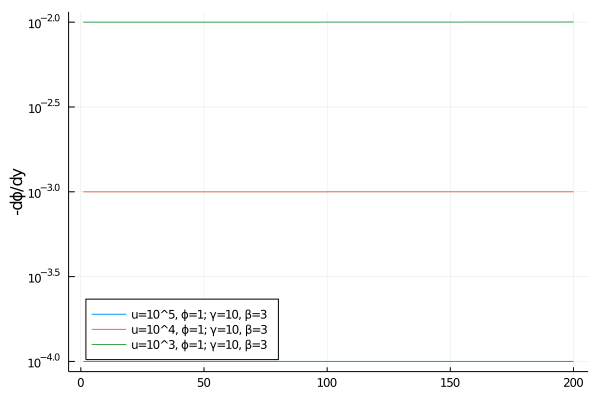

In [7]:
plot(-dϕdy(1e5, y, 1.0), label="u=10^5, ϕ=1; γ=10, β=3", legend=:bottomleft)
plot!(-dϕdy(1e4, y, 1.0), label="u=10^4, ϕ=1; γ=10, β=3")
plot!(-dϕdy(1e3, y, 1.0), label="u=10^3, ϕ=1; γ=10, β=3")
yaxis!("-dϕ/dy", :log10)

## Naïve solution

Just to get a feel for what is happening, it is useful to just do fixed steps in $y$ and see how things change. This is the aim of this piece of code.


In [8]:
function advance_solutions(y_current, val_current; dy=0.01)
    # Calculate new values from value at this y
    uc, ϕc, τc = val_current
    
    Δu = dudy(uc, y_current, ϕc, τc)*dy
    Δϕ = dϕdy(uc, y_current, ϕc)*dy
    Δτ = dτdy(uc)*dy
    
    println("Δu=$Δu Δϕ=$Δϕ Δτ=$Δτ")
    
    y_next = y_current+dy
    val_next = (uc+Δu, ϕc + Δϕ, τc + Δτ)
    
    return y_next, val_next
end
    
function simple_solve(n_steps; y_step=1e-4)
    # Naive solver
    
    y_start = 10

    ϕ0 = 1.0
    τ0 = 0.0
    u0 = 454.0
    
    y = zeros(n_steps)
    ϕ = zeros(n_steps)
    τ = zeros(n_steps)
    u = zeros(n_steps)
    
    val_current = (u0, ϕ0, τ0)
    y[1] = y_start
    u[1] = u0
    ϕ[1] = ϕ0
    τ[1] = τ0
    
    y_current = y_start
    for i=2:n_steps
        ynext, valnext = advance_solutions(y_current, val_current; dy=y_step)
        
        y[i] = ynext
        u[i] = valnext[1]
        ϕ[i] = valnext[2]
        τ[i] = valnext[3]
        
        val_current = valnext
        y_current = ynext
        
        if (ϕ[i] < 0)
            println("We have reached ymax<$y_current")
            break
        end
        
    end
  
    return (y=y, u=u, ϕ=ϕ, τ=τ)
end
    

simple_solve (generic function with 1 method)

In [28]:
# res = simple_solve(100; y_step=0.01);

In [29]:
#plot(res.y, res.u)

### Defining initial conditions

In this case the initial conditions are that $\tau(0) = 0$, $\phi(0) = 1$ given in Draine's book, but the initial condition on $u$ is less clear. In the 2011 paper this is discussed in more detail and $u(\approx 0)$ is set by the boundary conditions. Here I will just try it out in various ways. 

To do that I also need $n_0$ so that I can convert from $n$ to $u=n_0/n$.

In [11]:
function alpha_B(T)
    # Recombination coefficient Case B
    
    T4 = ustrip(T/(1e4u"K"))
    
    return 2.56e-13*T4^(-0.83)*u"cm^3/s"
end


function n0(;T=1e4*u"K", Q0=1e49*u"1/s", hnui=18*u"eV")
    
    T4 = ustrip(T/(1e4*u"K"))
    Q0p49 = ustrip(Q0/(1e49*u"1/s"))
    res = 4.54e5*(T4^4.66/Q0p49)*(18.0*u"eV"/hnui)^3*u"1/cm^3"
    return res
    
end


function lambda0(;T=1e4*u"K", Q0=1e49*u"1/s", hnui=18*u"eV")
    
    T4 = T/(1e4*u"K")
    Q0p49 = Q0/(1e49*u"1/s")
    res = 2.47e16*(Q0p49/T4^2.83)*(hnui/(18.0*u"eV"))^2*u"cm"
    return res
end

uval(n; kwargs...) = n0(kwargs...)/n


function gamma(;T=1e4*u"K", hnui=18*u"eV", σ=1e-21*u"1/cm^2")
    T4 = ustrip(T/(1e4*u"K"))
    
    return 11.2*T4^1.83*ustrip(18.0*u"eV"/hnui)*ustrip(σ/(1e-21*u"1/cm^2"))
end



gamma (generic function with 1 method)

## Calculating $\beta$, $Q_0$, and $\langle h\nu\rangle_i$

It is also useful to have a way to calculate $\beta$ and other quantities of relevance from the stellar spectrum. This function below calculates these quantities given a wavelength and flux axis.

We here define
$$L_i = \int_{0}^{\lambda_i} F_{\lambda} d\lambda$$
$$L_n = \int_{\lambda_i}^{\infty} F_{\lambda} d\lambda$$
$$\langle h\nu\rangle_i = \frac{\int_0^{\lambda_i} h c F_{\lambda}(\lambda)/\lambda d\lambda}{\int_0^{\lambda_i} F_{\lambda}(\lambda) d\lambda}$$


In [310]:

"Interpolate a spectrum. The routine strips units so the user needs to take care with that"
function interpolate_spectrum(λ, flux)
    itp = Spline1D(ustrip(λ), ustrip(flux));
    return itp
end
"""
  LnLi(λ, flux)

Calculate the integral of an interpolated spectrum

"""
function specQuantities(λ, itp)
        
    max_l = maximum(λ)
    min_l = minimum(λ)
    lambda_i = 911.267

    norm, err = quadgk(itp, min_l, max_l)
    Ln, err = quadgk(itp, lambda_i, max_l)
    Li, err = quadgk(itp, min_l, lambda_i)
    
    β = Ln/Li
    # The units are expected to be erg/s/angstrom for the flux so
    # this gives the units for the luminosities
    Ln = Ln*u"erg/s"
    Li = Li*u"erg/s"
    
    m1_int(x) = itp(x)/x
    mm1_int(x) = x*itp(x)
    norm, err = quadgk(itp, min_l, lambda_i)
    pre = Unitful.h*Unitful.c
    hnui, err = quadgk(m1_int, min_l, lambda_i)
    hnui = pre*hnui/norm
    Q0, err = quadgk(mm1_int, min_l, lambda_i)
    Q0 = Q0*u"erg/s"/pre
    
    # Finally adjust units because the integrals are done unitless so
    # we need to multiply my Angstrom (except for Ln/Li which are done above)
    hnui = uconvert(u"eV", hnui*1u"1/angstrom")
    Q0 = upreferred(Q0*1u"angstrom")
    
    return (Ln=Ln, Li=Li, hnui=hnui, Q0=Q0, β=β)
end


specQuantities

It is useful to have a black body to compare against to do this I take the black body formula which is
$$
B_\nu = \frac{2h}{c} \frac{\nu^3}{\exp(\frac{h\nu}{kT})-1} $$

and we want the integral of $B_\nu$ to a given energy $E_i=13.6$eV. This integral can be written as 

$$
I(E_1, E_2) = \pi \left(\frac{2h}{c}\right)  \left(\frac{kT}{h}\right)^4\,\int_{x_1}^{x_2} \frac{x^3}{e^x-1}\;dx,
$$
where $x_1=E_1/kT$ and $x_2=E_2/kT$.  The definition of $\beta$ is then

$$\beta = \frac{L_n}{L_i} = \frac{I(0, 13.6\mathrm{eV})}{I(13.6\mathrm{eV}, \infty)} $$

In [360]:
function Bnu(ν, T)
    z = Unitful.h.*ν./(Unitful.k.*T)
    2 .*Unitful.h.*ν^3/(Unitful.c^2 .*(exp(z).-1))
end

function Blambda(λ, T)
    z = Unitful.h.*Unitful.c ./(Unitful.k.*T*λ)
    2 .*Unitful.h.*Unitful.c^2/(λ^5 .*(exp(z).-1))
end
function PlanckAstro(λ, T; convert_to_L=true)
    Bl = Blambda(λ, T)
    
    # Now convert to erg/s/cm^3/A
    Bl = π*uconvert(u"erg/s/cm^2/angstrom", Bl)
    
    # And then to luminosities if requested
    if (convert_to_L)
        Bl=uconvert(u"erg/s/angstrom", Bl*4*π*radius_for_T(T)^2)
    end
    return ustrip(Bl)
end

"The radius relation for dwarfs from Sternberg, Hoffmann & Pauldrach (2003) "
radius_for_T(T) = (0.2*ustrip(T)/1e3+2)*u"Rsun"
    

radius_for_T

In [341]:
radius_for_T(45000)

11.0 R⊙

Let us sample a black-body over some reasonable range for testing with the equation above.

In [342]:

lrange = collect(LinRange(1., 6e4, 10000))
flux = [PlanckAstro(l*u"angstrom", 32000u"K") for l in lrange];

In [343]:
typeof(flux), typeof(lrange)

(Array{Float64,1}, Array{Float64,1})

In [344]:
itp = interpolate_spectrum(lrange, flux)

Spline1D(knots=[1.0,13.001 … 59988.0,60000.0] (9998 elements), k=3, extrapolation="nearest", residual=0.0)

In [345]:
res = specQuantities(lrange, itp)

(Ln = 1.902972483666804e38 erg s⁻¹, Li = 6.486414966237192e37 erg s⁻¹, hnui = 18.16723450143682 eV, Q0 = 2.3250052282640795e48 s⁻¹, β = 2.9337815936415947)

In [337]:
upreferred(res.Li/res.hnui)

1.2944291388249479e54 s⁻¹

In [13]:
ystart = 10
u0 = [454, 1, 0]
yspan = [ystart, 100]

p = [10, 3]

2-element Array{Int64,1}:
 10
  3

In [14]:
prob = ODEProblem(d2011system!, u0, yspan, p)

ODEProblem with uType Array{Int64,1} and tType Int64. In-place: true
timespan: (10, 100)
u0: [454, 1, 0]

Adding a call back to stop integration

In [15]:
condition(u, y, integrator) = u[2]
affect!(integrator) = terminate!(integrator)
cb = ContinuousCallback(condition, affect!);

In [16]:
sol = solve(prob, Tsit5(), callback=cb);

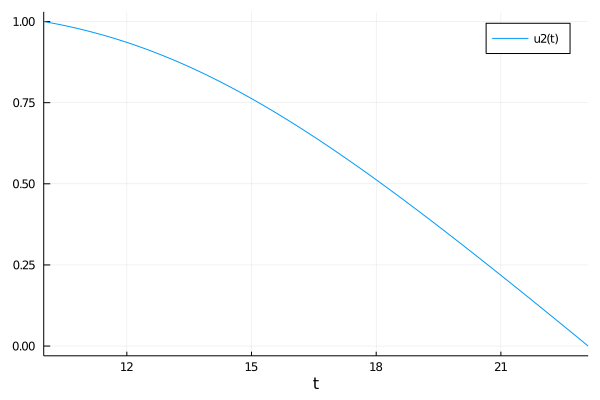

In [17]:
plot(sol, vars=[(0, 2)])

In [357]:
nsteps = 100 #number of points along y
ys = range(0, stop=30, length=nsteps)
u_values = sol(ys, idxs=1)
nvalues = ustrip(n0())./u_values;

In [358]:
yax = [uconvert(u"pc", y*lambda0()) for y in ys];

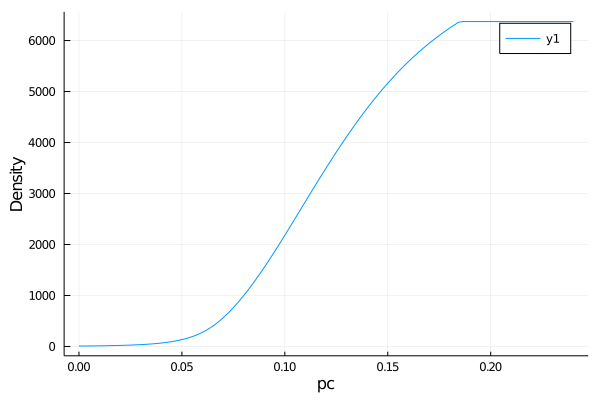

In [359]:
plot(yax, nvalues, ylabel="Density")


In [ ]:
savefig("dustyHII-wo-gravity-example.png");

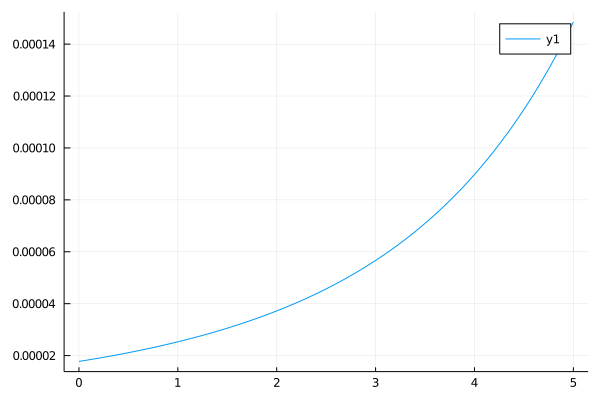

In [348]:
plot(ys, 1.0./u_values)

## Calculation of ymax etc

Finally we need some routines that can take the output from the solution and calculate various convenient quantities from it.

In [20]:
function phi(y)
    return sol(y; idxs=2)
end
function ufunc(y)
    return sol(y; idxs=1)
end

ufunc (generic function with 1 method)

In [32]:
# Since ymax is defined as phi(ymax)=0 which is also the stop criterion for the solver.
ymax(solution) = maximum(solution.t)
ymin(solution) = minimum(solution.t)

# RMS density 



function n_rms(solution; kwargs...)
    ymx = ymax(solution)
    integrand_rms(y) = y^2/solution(y; idxs=1)^2
    
    int, dint = quadgk(integrand_rms, ymin(solution), ymx)
    
    return n0(;kwargs...)*sqrt(3.0*int/ymx^3)
end
function n_mean(solution; kwargs...)
    ymx = ymax(solution)
    integrand_mean(y) = y^2/solution(y; idxs=1)
    
    int, dint = quadgk(integrand_mean, ymin(solution), ymx)
    
    return 3.0*n0(;kwargs...)*int/ymx^3
end
    
p_edge(sol, T; kwargs...) = 2.0*n0(;kwargs...)*Unitful.k*T/sol(ymax(sol), idxs=1)

function Rs(sol, Q0, T)
    Q0p49 = ustrip(Q0/1e49)
    nrms_3 = n_rms(sol)/(1e3u"1/cm^3")
    T4 = ustrip(T/1e4)
    
    return 2.10e18*Q0p49^(1/3.)*T4^0.25/nrms_3^(2/3.)*u"cm"
end

taud0(sol, Q0, T; σ=1e-21u"cm^2") = n_rms(sol)*Rs(sol, Q0, T)*σ

taud0 (generic function with 1 method)

In [33]:
n_rms(sol, T=1e4), n_mean(sol, T=1e4)

(4742.281469547198 cm⁻³, 4348.453832478652 cm⁻³)

In [23]:
taud0(sol, 1e49, 1e4)

3.5281610714028933

In [24]:
p_edge(sol, 1e4u"K")

1.7596732684617422e-15 J cm⁻³

# Putting it all together

This seems to work above, so now we can put together the solution with a range of other calculations that are useful for interpretation. For this we need create a function that does the various steps above.

In [40]:
struct Draine2011
    solution::ODESolution
    nrms
    nmean
    ymax::Real
end

function draine2011model(γ, β; u0=454, ystart=10, yend=100, T=10^4*u"K",
        Q0=1e49*u"1/s", hnui=18*u"eV", σ=1e-21*u"1/cm^2" )
    
    starting_point = [u0, 1, 0]
    yspan = [ystart, yend]

    p = [γ, β]
    
    prob = ODEProblem(d2011system!, starting_point, yspan, p)
    
    sol = solve(prob, Tsit5(), callback=cb);
    nrms = n_rms(sol; T=T, Q0=Q0, hnui=hnui)
    nmean = n_mean(sol; T=T, Q0=Q0, hnui=hnui)
    
    ymx = ymax(sol)
    
    return Draine2011(sol, nrms, nmean, ymx)
    
end    
    

draine2011model (generic function with 1 method)

In [35]:
sim = draine2011model(10.0, 3.0; ystart=5);

In [41]:
function phi(y, model::Draine2011)
    return model.solution(y; idxs=2)
end
function ufunc(y, model::Draine2011)
    return model.solution(y; idxs=1)
end

ufunc (generic function with 2 methods)

In [42]:
phi(2.0, sim)

1.0211809310318023